In [1]:
%matplotlib qt

In [2]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [112]:
# Use the .fif files produced from kit2fiff packages
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)

# new = new gel ; original: old gel

EEG_cntFile = root_data_path / Path('eeg_20250610_test_new_MMN_Notched.cnt') #eeg_20250610_test_original_noNotch.cnt
#LDT_raw =  mne.io.read_raw_kit(LDT_confile, stim = [195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進
#LDT_raw.plot()
#events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

MMN_raw = mne.io.read_raw_cnt(EEG_cntFile, eog="header", preload=True)
#MMN_raw.plot()

n_MMN_raw = MMN_raw.copy()
#n_MMN_filtered = n_MMN_raw.notch_filter(freqs=50, picks="all")
n_MMN_raw.plot()
#n_MMN_filtered.plot()
print(n_MMN_raw.info)

# Calculate the power spectrum density to examine the power in each frequency.
n_MMN_raw.compute_psd(fmin=1, fmax=100).plot()#.(fmax=100)

# Save the cnt into .fif for a easier further analysis
fif_DIR = root_data_path / 'rawfif_all'
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
fif_DIR.mkdir(exist_ok=True)

n_MMN_raw.save(uncut_fif_DIR / Path('eeg_20250610_test_new_MMN_Notched.fif'), overwrite=True)

/Users/neuroling/Downloads/20250610_EEG-Demo
Reading 0 ... 415231  =      0.000 ...   405.499 secs...
Using pyopengl with version 3.1.1a1
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 1 EOG, 1 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 07:03:10 UTC
 nchan: 2
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 5 items (dict)
>
Effective window size : 2.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Overwriting existing file.
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_new_MMN_Notched.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_new_MMN_Notched.fif
[done]


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/3384534997.py:30: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_new_MMN_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  n_MMN_raw.save(uncut_fif_DIR / Path('eeg_20250610_test_new_MMN_Notched.fif'), overwrite=True)


Channels marked as bad:
['Trigger']


In [53]:
n_MMN_raw.ch_names # Where are the annotations

['Fz_1', 'Trigger']

In [84]:
# This is the original brain data's triggers
'''
Triggers_ID:
12345 >> the start of task
55 >> the end of task
20 ~ 24 >> the start of questions' texts (irrelevant in here, please ignore it)
'''

## Segment the EEG according to tasks, 5 parts in total.
events_ann_ndArray = mne.events_from_annotations(n_MMN_raw)[0]
print(events_ann_ndArray)
print(type(events_ann_ndArray))
print(len(events_ann_ndArray))
print(mne.events_from_annotations(n_MMN_raw)[1], len(mne.events_from_annotations(n_MMN_raw)[1]))

events_id_DICT = {'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11}
raw_sfreq = n_MMN_raw.info['sfreq'] # supposedly to be 1000 Hz
fifname_LIST = ["eyeOpen_2min", "eyeClose_2min", "Blink_60count", "HEOG_60count", "VEOG_60count"]

# Get the start points in every 3 segment, staring from index[0]
start_tNDarray = events_ann_ndArray[::3]
print(start_tNDarray)
print(len(start_tNDarray))

# Get the end points in every 3 segment, staring from index[2]
end_tNDarray = events_ann_ndArray[2::3]
print(end_tNDarray)
print(len(end_tNDarray))

# segment the EEG data according to the points that are going to be converted into times, and save the raw EEG files
for i in range(5):
    print(start_tNDarray[i][0]/int(raw_sfreq), end_tNDarray[i][0]/int(raw_sfreq))
    # in here, we exclude the +0.5 at the end of the end points for the reason of 0.5 delay when the questions start trigger appear
    cut_eeg = n_MMN_raw.copy().crop((start_tNDarray[i][0]/int(raw_sfreq)), (end_tNDarray[i][0]/int(raw_sfreq)))
    cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


"""
epochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)
                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)
"""

Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
[[  8744      0      1]
 [ 68651      0      3]
 [144131      0     11]
 [146165      0      2]
 [209144      0      4]
 [278897      0     11]
 [280916      0      8]
 [346966      0      5]
 [357762      0     11]
 [359970      0      9]
 [432166      0      6]
 [439272      0     11]
 [441476      0     10]
 [510597      0      7]
 [520315      0     11]]
<class 'numpy.ndarray'>
15
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
{'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11} 11
[[  8744      0      1]
 [146165      0      2]
 [280916      0      8]
 [359970      0      9]
 [441476      0     10]]
5
[[144131      0     11]
 [278897      0     11]
 [357762      0     11]
 [439272      0     11]
 [520315      

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeOpen_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeClose_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_L

Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/HEOG_60count_new_Notched.fif
[done]
431.12890625 508.1201171875
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
[done]


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


'\nepochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)\n                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)\n'

Effective window size : 2.000 (s)


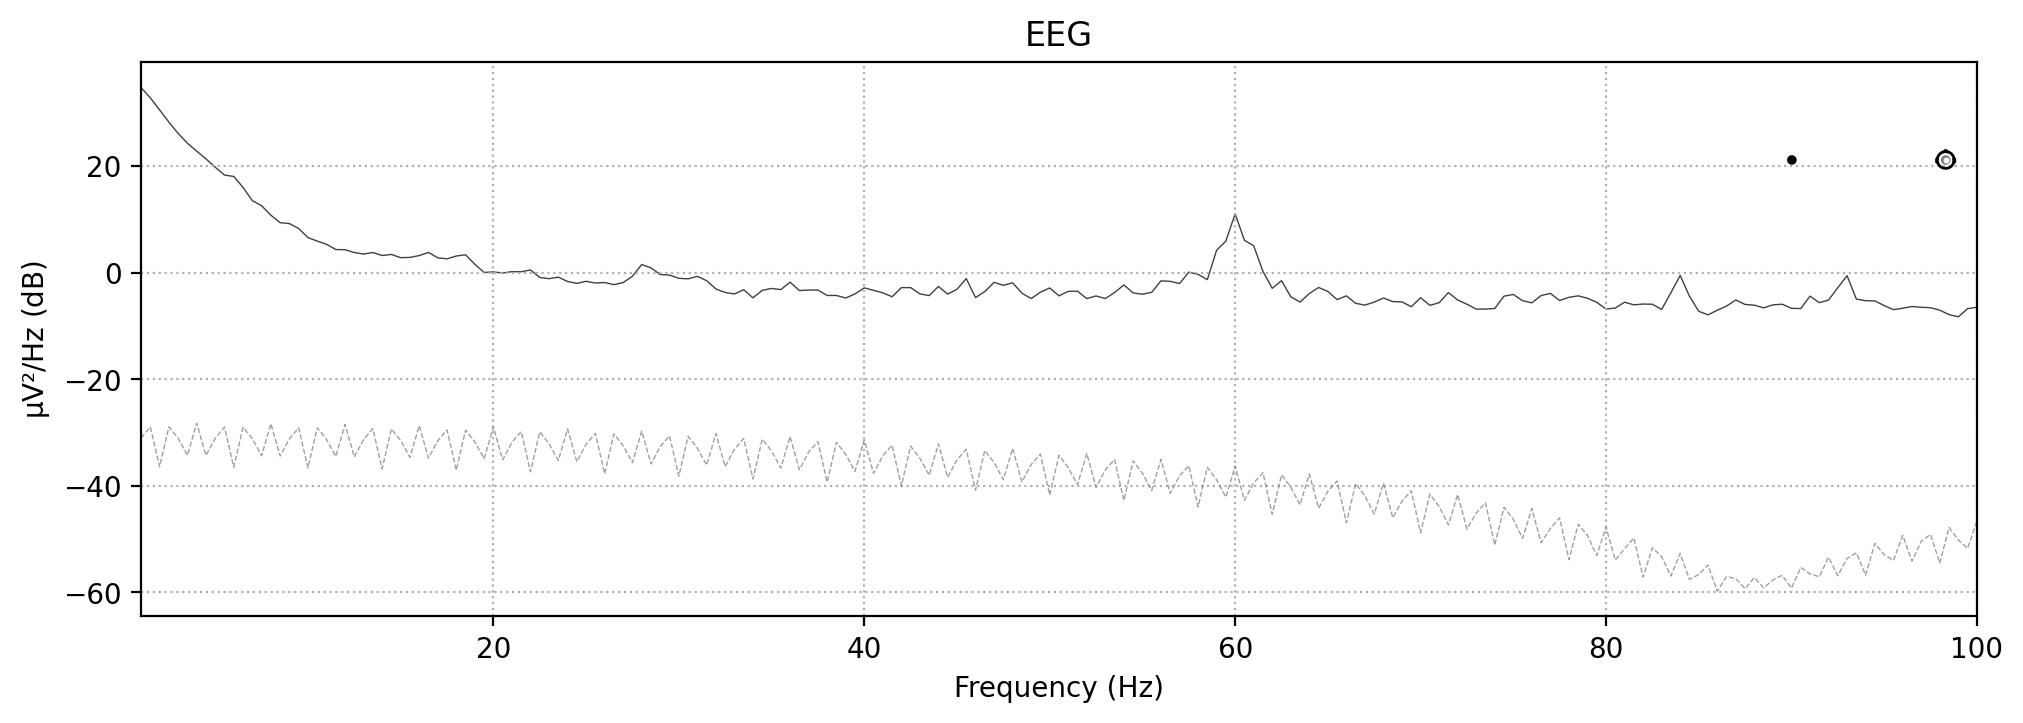

2025-08-22 18:03:51.157 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:55.698 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:57.323 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:57.590 python[16801:20845248] +[CATransaction synchronize] called within transaction


In [47]:
raw_MMN_fif.compute_psd(fmin=1, fmax=100).plot()


In [83]:
# MMN data analysis
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'

# noNotch
noNotch_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), preload=True)
# Check whether the ch exists
print(noNotch_raw_MMN_fif.info['ch_names'])
print(noNotch_raw_MMN_fif.get_channel_types())
# Rename the channels
noNotch_raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
noNotch_raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})


#Notched
Notched_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_Notched.fif'), preload=True)
# Check whether the ch exists
print(Notched_raw_MMN_fif.info['ch_names'])
print(Notched_raw_MMN_fif.get_channel_types())
# Rename the channels
Notched_raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
Notched_raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})

merged_MMN_LIST = [noNotch_raw_MMN_fif, Notched_raw_MMN_fif]
#merged_MMN_LIST.plot()

merged_MMN = mne.concatenate_raws(merged_MMN_LIST)
merged_MMN.compute_psd(fmin=1, fmax=100).plot()
merged_MMN.save(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), overwrite=True)

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_noNotch.fif...
    Range : 0 ... 407295 =      0.000 ...   397.749 secs
Ready.
Reading 0 ... 407295  =      0.000 ...   397.749 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_Notched.fif...
    Range : 0 ... 410623 =      0.000 ...   400.999 secs
Ready.
Reading 0 ... 410623  =      0.000 ...   400.999 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Effective window size : 2.000 (s)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/2490445872.py:7: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  noNotch_raw_MMN_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/2490445872.py:17: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif

Overwriting existing file.
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_MMN_merged_raw.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_MMN_merged_raw.fif
[done]


Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_MMN_merged_raw.fif...
    Range : 0 ... 817919 =      0.000 ...   798.749 secs
Ready.
Reading 0 ... 817919  =      0.000 ...   798.749 secs...
Effective window size : 2.000 (s)
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/new_MMN_merged_raw.fif...
    Range : 0 ... 825599 =      0.000 ...   806.249 secs
Ready.
Reading 0 ... 825599  =      0.000 ...   806.249 secs...
Effective window size : 2.000 (s)


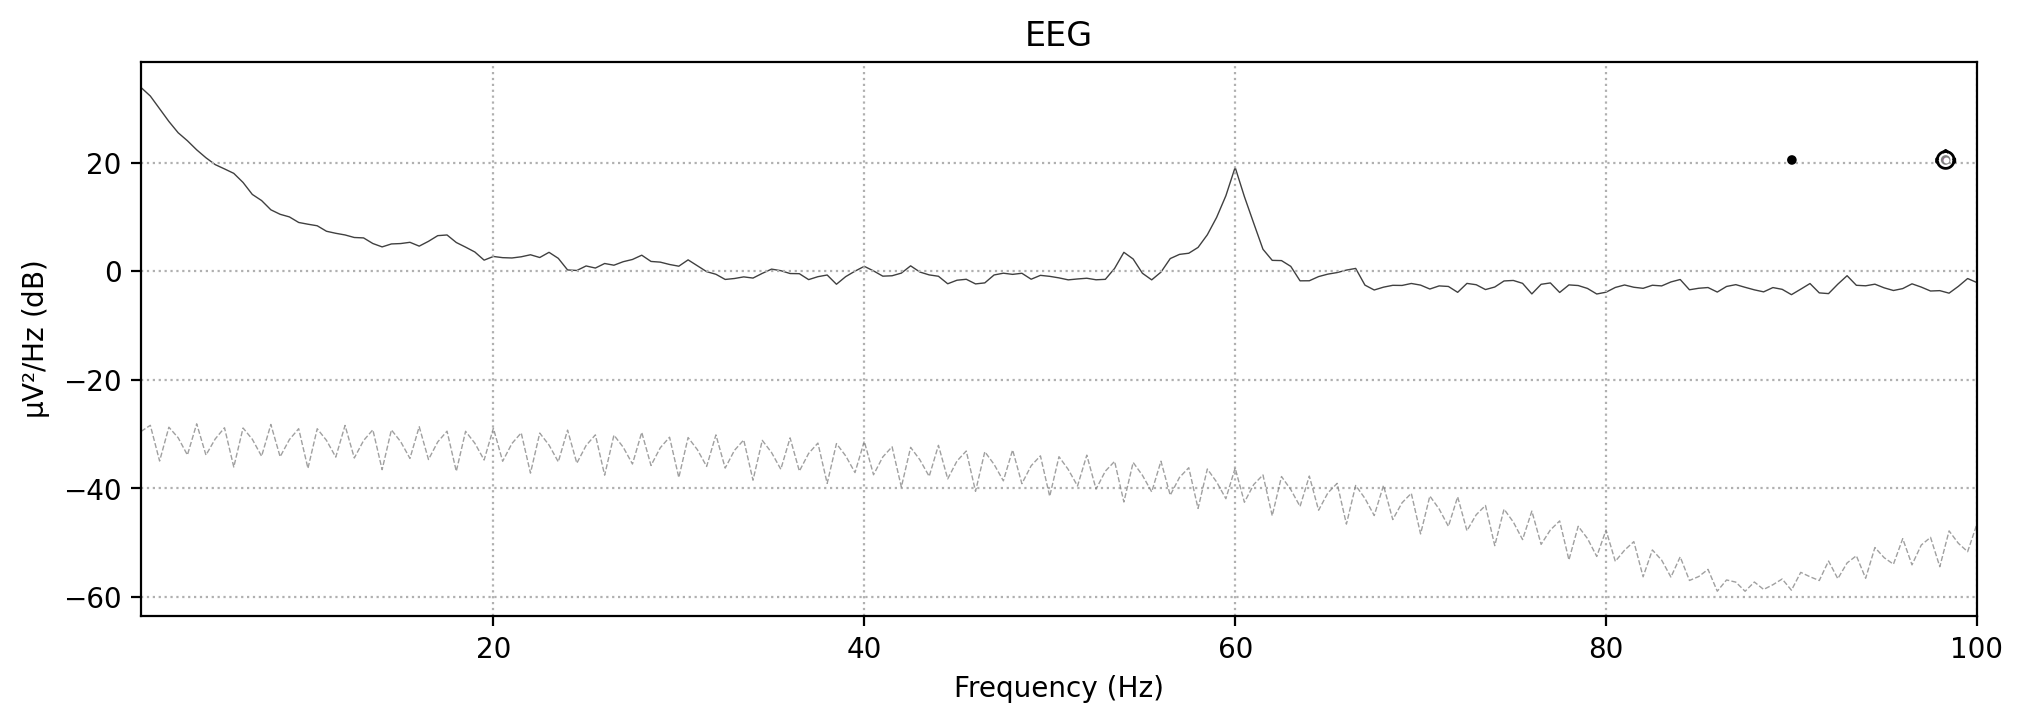

In [84]:
# Compute the psd of two different kinds of gel
orig_MMN_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), preload=True)
orig_MMN_merged_fif.compute_psd(fmin=1, fmax=100).plot()

new_MMN_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('new_MMN_merged_raw.fif'), preload=True)
#new_MMN_merged_fif.compute_psd(fmin=1, fmax=100).plot()

In [93]:
# Creating the new epochs
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
merged_MMN = mne.io.read_raw_fif(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), preload=True)

# Set the event markers according to the annotations
MMN_eventsArray = mne.events_from_annotations(merged_MMN)[0]
MMN_events = MMN_eventsArray #mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
MMN_event_id = {'standard':1,'deviant_2':2, 'deviant_3': 3}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

epoch_DIR = fif_DIR / 'MMN_epochs'
merged_MMN.filter(0, 30, phase= 'zero-double').resample(500)
#raw_MMN_fif.resample(500)
#raw_MMN_fif.notch_filter(freqs=60)
n_epoch_MMN = mne.Epochs(merged_MMN, MMN_events, MMN_event_id, tmin, tmax, baseline=baseline, preload = True)
print(n_epoch_MMN.info)
n_epoch_MMN.save(epoch_DIR / Path('orig_MMN_merged_epochs.fif'), overwrite=True)
n_epoch_MMN

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/new_MMN_merged_raw.fif...
    Range : 0 ... 825599 =      0.000 ...   806.249 secs
Ready.
Reading 0 ... 825599  =      0.000 ...   806.249 secs...
Used Annotations descriptions: ['1', '2', '3', '4']
Filtering raw data in 2 contiguous segments
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 451 samples (0.440 s)

Not setting metadata
1000 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1000 events and 401 original time points

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/1109758814.py:25: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  n_epoch_MMN.save(epoch_DIR / Path('new_MMN_merged_epochs.fif'), overwrite=True)


Number of events,499
Events,deviant_2: 50deviant_3: 49standard: 400
Time range,-0.100 – 0.700 s
Baseline,-0.100 – 0.000 s


In [101]:
# Recalculate the merged MMN's evoked
epoch_DIR = fif_DIR / 'MMN_epochs'
epoch_MMN = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)

fig_DIR = root_data_path / 'figs'
MMN_figs_DIR = fig_DIR / 'MMN_figs'

epoch_DIR.mkdir(exist_ok=True)
fig_DIR.mkdir(exist_ok=True)
MMN_figs_DIR.mkdir(exist_ok=True)

# epochs to evoked
evoked_standard = epoch_MMN['standard'].average()
evoked_deviant_2 = epoch_MMN['deviant_2'].average()
evoked_deviant_3 = epoch_MMN['deviant_3'].average()

# Plot mmn differences
tmp = [evoked_standard, evoked_deviant_2, evoked_deviant_3]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mmn_fig = mne.viz.plot_compare_evokeds(tmp, colors = colors) #, axes = 'topo')
#mmn_plot

"""
# Save fig
fig_DIR = root_data_path / 'MMN_figs'
fig_DIR.mkdir(exist_ok=True)
mmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)
"""
#plt.savefig(meg_data_path / Path('H-minus-L_evoked_topomap.png'), overwrite=True). # Check this later

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif ...
    Found the data of interest:
        t =     -99.61 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/192725831.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_noFiltSamp_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoch_MMN = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_noFiltSamp_epochs.fif'), preload=True)


"\n# Save fig\nfig_DIR = root_data_path / 'MMN_figs'\nfig_DIR.mkdir(exist_ok=True)\nmmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)\n"

2025-08-22 21:36:05.108 python[16801:20845248] +[CATransaction synchronize] called within transaction


In [107]:
print(n_epoch_MMN.drop_log())
n_epoch_MMN.plot_drop_log()

TypeError: 'tuple' object is not callable

In [84]:
#MMN_merged_epochLIST.compute_psd(fmin=1, fmax=100).plot()
#evk_spectrum.plot(picks="data", exclude="bads")

epo_spectrum = MMN_merged_epochLIST.compute_psd()
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f"\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}")
epo_spectrum

    Using multitaper spectrum estimation with 7 DPSS windows

PSDs shape: (470, 1, 201), freqs shape: (201,)


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Epochs
Number of epochs,470
Dims,"epoch, channel, freq"
Estimation method,multitaper
Number of channels,2
Number of frequency bins,201
Frequency range,0.00 – 249.38 Hz


In [104]:
# Use Amplitude-Based Heuristics

new_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_epochs.fif'), preload=True)
orig_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('original_MMN_merged_epochs.fif'), preload=True)
new_data = new_MMN_merged_fif.get_data(picks='Fz_1')[0]  # assuming Fz_1 is your only channel
orig_data = orig_MMN_merged_fif.get_data(picks='Fz_1')[0]  # assuming Fz_1 is your only channel

new_peak_to_peak = new_data.max() - new_data.min()
orig_peak_to_peak = orig_data.max() - orig_data.min()

print(f"New Peak-to-peak amplitude: {new_peak_to_peak*1e6:.2f} µV")
print(f"Orignal Peak-to-peak amplitude: {orig_peak_to_peak*1e6:.2f} µV")

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/297731866.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/new_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('new_MMN_merged_epochs.fif'), preload=True)


Not setting metadata
499 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/original_MMN_merged_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
470 matching events found
No baseline correction applied
0 projection items activated
New Peak-to-peak amplitude: 39.34 µV
Orignal Peak-to-peak amplitude: 39.47 µV


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/297731866.py:4: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/MMN_epochs/original_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_fif = mne.read_epochs(epoch_DIR / Path('original_MMN_merged_epochs.fif'), preload=True)


'\n# Compute Variance or SNR as Proxy for Conductivity\nepochs = mne.Epochs(raw, events, event_id, tmin=-0.1, tmax=0.8, preload=True)\ndata = epochs.get_data(picks=\'Fz_1\')\nvariances = data.var(axis=2).flatten()\nprint(f"Variance across trials: {variances.mean():.2e} µV²")\n'

In [24]:
# get to know the reason of bad epoch drop
print(epoch_LDT.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 117',), (), ())
